### Constant loading and mutant loading for PMMA


The next step of our internship is to simulate the nonmonotonic aging and memory for viscoelastic rough surface contact. Dillavou(2018)[1] provides experimental data for PMMA(poly methylmethacrylate) rough contact, and we mainly focus on the real area of contact between the blocks $A_R$:

![](figures/contact_area_VS_time_Dillavou_2018.png)

Glassy dynamics in the real area of contact: $A_R$ and $F_N$ versus time for a typical two-step protocol with $F_1=100 \mathrm{~N}$, $T_W=1000 \mathrm{~s}, F_2=25 \mathrm{~N}$.

About our numerical implementation, we basically apply Generalized Maxwell model, which is a widely-used viscoelastic model. The generalized Maxwell model has several units of the Maxwell elements connected in parallel (also called the Weichert model if a free spring is included). Wayne(2011)[2] presents a 3-D semi-analytical contact model for viscoelastic materials, utilizing the Conjugate Gradient method and Fast Fourier Transform to efficiently simulate contact responses under complex loading conditions. 

In Wayne(2011)[2], the relaxation modulus function, $\psi_r(t)$, is defined to be the ratio of the stress history over the constant strain:

$$
\psi_r(t)=\frac{\sigma(t)}{\varepsilon_0}
$$

Likewise, the creep compliance function $\varphi_c(t)=\frac{\varepsilon(t)}{\sigma_0}$ is used to represent the strain creep behavior of a viscoelastic material under a constant stress.

And with generalized Maxwell model, the effective relaxation modulus can be written as:

$$
\psi_r(t)=\left[g_0+\sum_{i=1}^n g_i \exp \left(-t / \tau_i\right)\right] H(t)
$$

Here, $\tau_i$ is the relaxation time of one elemental model, which equals the ratio of the dashpot viscosity $\eta_i$ to the spring stiffness $g_i$, and $H(t)$ the Heaviside step function.

The typical value of the Poisson ratio of PMMA is about 0.35~0.4; in this study, we keep it simple with incompressible behaviour, $\nu=0.5$.

Kumar(2004)[3] have conducted a standard relaxation test under uniaxial compression to characterize the viscoelastic response of PMMA. The measured relaxation modulus curve up to 1000 sec is shown:



![](figures/Measured_relaxation_modulus_function_of_PMMA.png)



A two-term Prony series is utilized here to fit the relaxation curve of PMMA (curve fitting R-squared=0.99957):

$$
\begin{aligned}
\psi_r(t)= & 1429.71+184.62 \exp \left(-\frac{t}{8.93}\right) \\
& +191.06 \exp \left(-\frac{t}{117.96}\right), \quad(\mathrm{MPa})
\end{aligned}
$$

Here we will use tamaas viscoelastic function to reproduce this simulation.

### For surface, we can set rms to control the random surface generation(https://tamaas.readthedocs.io/en/latest/api_reference.html#tamaas._tamaas.Statistics2D.contact)

### Q1: Sample surface roughness ranges from the original extruded PMMA (11 nm rms) to surfaces lapped with 220 grit polishing paper (1.8 μmrms)? and what about surface.size?
A1: We can compute rms[staticcomputeRMSHeights(arg0: GridWrap<T, dim>)→ float] and "normalize" it

We should apply surface with mm scale.

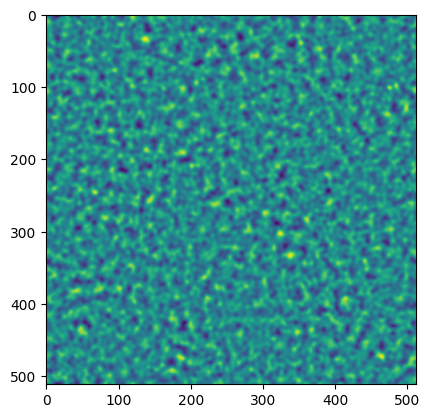

In [12]:
import tamaas as tm
import matplotlib.pyplot as plt
import numpy as np

from tamaas.utils import publications

# Initialize threads and fftw
tm.set_log_level(tm.LogLevel.info)  # Show progression of solver

# Surface size
n = 512

# Surface generator
sg = tm.SurfaceGeneratorFilter2D([n, n])
sg.random_seed = 1

# Spectrum
sg.spectrum = tm.Isopowerlaw2D()

# Parameters
sg.spectrum.q0 = 16
sg.spectrum.q1 = 16
sg.spectrum.q2 = 64
sg.spectrum.hurst = 0.8

# Generating surface
surface = sg.buildSurface()
surface /= tm.Statistics2D.computeSpectralRMSSlope(surface)

plt.imshow(surface)


For two Maxwell branches in generalized Maxwell model, we have their shear moduli and relaxation time(characteristic time):

```cpp
shear_modulus = [184.62, 191.06]
characteristic_time = [8.93, 117.96]
```

### Q2: how can we set $G_\infty$ in tamaas?

A2: In Wayne(2011)[2], we have $g_0$ as shear modulus for elastic branch of generalized Maxwell model, and in numerical implementation we use `model.getShearModulus()` to get shear modulus for this branch, such that we times a factor for material elastic property.

In [13]:
# Creating model
model = tm.ModelFactory.createModel(tm.model_type.basic_2d, [1., 1.], [n, n])

# Setting parameters
model.nu = 0.5
model.E = 1429.71*2*(1+model.nu) #times a factor for material elastic property
model.E_star
#E_star = model.E / (1 - model.nu**2)

shear_modulus = [184.62, 191.06]
characteristic_time = [8.93, 117.96]

In [14]:
t0 = 0
t1 = 1000
time_steps = 50
dt = (t1 - t0)/time_steps

### Q3: getTraction to get contact area for rough surface??

 Iter          Cost_f           Error


    0   -1.644390e+03    2.949945e+00
   76   -2.745810e+03    8.862949e-13
 Iter          Cost_f           Error
    0   -1.644381e+03    2.949888e+00
   76   -2.745777e+03    7.944278e-13
 Iter          Cost_f           Error
    0   -1.644375e+03    2.949856e+00
   76   -2.745759e+03    7.461784e-13
 Iter          Cost_f           Error
    0   -1.644372e+03    2.949834e+00
   86   -2.745747e+03    8.701676e-13
 Iter          Cost_f           Error
    0   -1.644369e+03    2.949818e+00
   76   -2.745738e+03    8.908499e-13
 Iter          Cost_f           Error
    0   -1.644367e+03    2.949804e+00
   84   -2.745730e+03    9.823673e-13
 Iter          Cost_f           Error
    0   -1.644365e+03    2.949792e+00
   76   -2.745723e+03    9.761529e-13
 Iter          Cost_f           Error
    0   -1.644363e+03    2.949782e+00
   75   -2.745717e+03    8.209542e-13
 Iter          Cost_f           Error
    0   -1.644362e+03    2.949773e+00
   84   -2.745712e+03    9.495581e-13
 Iter       

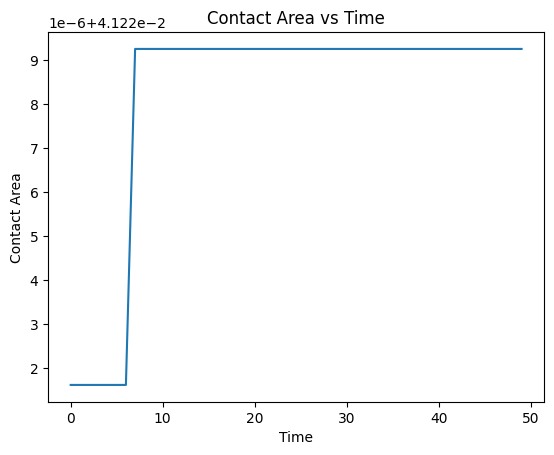

In [15]:
#Solver
solver = tm.MaxwellViscoelastic(model, surface, 1e-12, dt, shear_modulus, characteristic_time)

# Solve for target pressure
p_target1 = 100#avarge pressure
p_target2 = 25#avarge pressure

tm.Statistics2D.contact(model.traction)
model.traction[:] = 0
model.displacement[:] = 0

# Solve for target pressure
contact_area = []
for i in range(time_steps):
    model.traction[:] = 0
    model.displacement[:] = 0
    #if i < 10:
    solver.solve(p_target1)
    #else:
    #    solver.solve(p_target2)
    contact_area.append(tm.Statistics2D.contact(model.traction))

plt.plot(range(time_steps), contact_area)
plt.xlabel('Time')
plt.ylabel('Contact Area')
plt.title('Contact Area vs Time')
plt.show()

 Iter          Cost_f           Error


    0   -2.065357e+03    2.013904e-04
   41   -2.745810e+03    8.657936e-13
 Iter          Cost_f           Error
    0   -2.065326e+03    2.661352e-05
   38   -2.745777e+03    5.811970e-13


100.00000000000017


 Iter          Cost_f           Error
    0   -2.065311e+03    1.469060e-05
   37   -2.745759e+03    6.134407e-13


100.00000000000013


 Iter          Cost_f           Error
    0   -2.065301e+03    9.971978e-06
   39   -2.745747e+03    9.153543e-13


99.9999999999999


 Iter          Cost_f           Error
    0   -2.065293e+03    7.743412e-06
   35   -2.745738e+03    6.533281e-13


99.99999999999972


 Iter          Cost_f           Error
    0   -2.065286e+03    6.427406e-06
   37   -2.745730e+03    8.020285e-13


99.99999999999991


 Iter          Cost_f           Error
    0   -2.065281e+03    5.489198e-06
   35   -2.745723e+03    6.760123e-13


99.9999999999999


 Iter          Cost_f           Error
    0   -2.065276e+03    4.741564e-06
   34   -2.745717e+03    7.980482e-13


99.9999999999999


 Iter          Cost_f           Error
    0   -2.065271e+03    4.113888e-06
   33   -2.745712e+03    9.461889e-13


99.99999999999993


 Iter          Cost_f           Error
    0   -2.065268e+03    3.575363e-06
   34   -2.745708e+03    9.972351e-13


99.99999999999979


 Iter          Cost_f           Error
    0   -6.377567e+02    1.156747e+00
   48   -8.604723e+02    7.117442e-13


99.99999999999993


 Iter          Cost_f           Error
    0   -6.285293e+02    2.262965e-06
   25   -8.604760e+02    5.712735e-13


24.999999999999996


 Iter          Cost_f           Error
    0   -6.285303e+02    1.968684e-06
   25   -8.604776e+02    5.043467e-13


25.000000000000004


 Iter          Cost_f           Error
    0   -6.285308e+02    1.712734e-06
   25   -8.604785e+02    4.305546e-13


24.99999999999996


 Iter          Cost_f           Error
    0   -6.285311e+02    1.490080e-06
   24   -8.604791e+02    8.802265e-13


25.00000000000005


 Iter          Cost_f           Error
    0   -6.285313e+02    1.296379e-06
   24   -8.604795e+02    7.624858e-13


25.00000000000004


 Iter          Cost_f           Error
    0   -6.285315e+02    1.127860e-06
   24   -8.604799e+02    6.609936e-13


24.999999999999996


 Iter          Cost_f           Error
    0   -6.285317e+02    9.812478e-07
   24   -8.604803e+02    5.776314e-13


24.999999999999964


 Iter          Cost_f           Error
    0   -6.285318e+02    8.536943e-07
   23   -8.604805e+02    8.724816e-13


24.999999999999968


 Iter          Cost_f           Error
    0   -6.285319e+02    7.427217e-07
   23   -8.604808e+02    7.580073e-13


24.999999999999986


 Iter          Cost_f           Error
    0   -6.285320e+02    6.461747e-07
   22   -8.604810e+02    9.785271e-13


24.99999999999999


/tmp/ipykernel_107565/3812638756.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()
 Iter          Cost_f           Error
    0   -6.285321e+02    5.621778e-07
   22   -8.604812e+02    8.523369e-13


25.00000000000002


 Iter          Cost_f           Error
    0   -6.285322e+02    4.891000e-07
   22   -8.604813e+02    7.367627e-13


24.99999999999994


 Iter          Cost_f           Error
    0   -6.285323e+02    4.255216e-07
   22   -8.604815e+02    6.449732e-13


24.999999999999964


 Iter          Cost_f           Error
    0   -6.285323e+02    3.702078e-07
   22   -8.604816e+02    5.597060e-13


25.000000000000025


 Iter          Cost_f           Error
    0   -6.285324e+02    3.220842e-07
   22   -8.604817e+02    4.856242e-13


25.000000000000043


 Iter          Cost_f           Error
    0   -6.285324e+02    2.802163e-07
   21   -8.604818e+02    8.939555e-13


24.99999999999996


 Iter          Cost_f           Error
    0   -6.285325e+02    2.437910e-07
   21   -8.604819e+02    7.778085e-13


25.000000000000025


 Iter          Cost_f           Error
    0   -6.285325e+02    2.121005e-07
   21   -8.604820e+02    6.767070e-13


24.999999999999957


 Iter          Cost_f           Error
    0   -6.285325e+02    1.845294e-07
   20   -8.604820e+02    9.396637e-13


25.0


 Iter          Cost_f           Error
    0   -6.285325e+02    1.605426e-07
   20   -8.604821e+02    8.213631e-13


25.000000000000053


 Iter          Cost_f           Error
    0   -6.285326e+02    1.396736e-07
   20   -8.604821e+02    7.082619e-13


24.999999999999968


 Iter          Cost_f           Error
    0   -6.285326e+02    1.215174e-07
   20   -8.604822e+02    6.107276e-13


25.0000000000001


 Iter          Cost_f           Error
    0   -6.285326e+02    1.057213e-07
   20   -8.604822e+02    5.401407e-13


25.000000000000014


 Iter          Cost_f           Error
    0   -6.285326e+02    9.197849e-08
   20   -8.604822e+02    4.634777e-13


25.00000000000006


 Iter          Cost_f           Error
    0   -6.285326e+02    8.002221e-08
   20   -8.604823e+02    3.967845e-13


25.000000000000014


 Iter          Cost_f           Error
    0   -6.285326e+02    6.962011e-08
   19   -8.604823e+02    8.710459e-13


25.000000000000007


 Iter          Cost_f           Error
    0   -6.285327e+02    6.057027e-08
   19   -8.604823e+02    7.535017e-13


25.00000000000003


 Iter          Cost_f           Error
    0   -6.285327e+02    5.269669e-08
   18   -8.604823e+02    9.013295e-13


25.00000000000002


 Iter          Cost_f           Error
    0   -6.285327e+02    4.584661e-08
   18   -8.604823e+02    7.892532e-13


24.999999999999943


 Iter          Cost_f           Error
    0   -6.285327e+02    3.988701e-08


25.000000000000018


   18   -8.604823e+02    6.798957e-13
 Iter          Cost_f           Error
    0   -6.285327e+02    3.470208e-08
   18   -8.604824e+02    5.966503e-13


24.999999999999954


 Iter          Cost_f           Error
    0   -6.285327e+02    3.019110e-08
   17   -8.604824e+02    8.923515e-13


25.00000000000001


 Iter          Cost_f           Error
    0   -6.285327e+02    2.626634e-08
   17   -8.604824e+02    7.717232e-13


24.99999999999997


 Iter          Cost_f           Error
    0   -6.285327e+02    2.285201e-08
   17   -8.604824e+02    6.723734e-13


24.999999999999964


 Iter          Cost_f           Error
    0   -6.285327e+02    1.988141e-08
   17   -8.604824e+02    5.865926e-13


24.99999999999999


 Iter          Cost_f           Error
    0   -6.285327e+02    1.729703e-08
   16   -8.604824e+02    9.467538e-13


25.000000000000014


 Iter          Cost_f           Error
    0   -6.285327e+02    1.504838e-08
   16   -8.604824e+02    8.244630e-13


24.999999999999957


 Iter          Cost_f           Error
    0   -6.285327e+02    1.309224e-08
   16   -8.604824e+02    7.155560e-13


25.00000000000003


 Iter          Cost_f           Error
    0   -6.285327e+02    1.139038e-08
   15   -8.604824e+02    9.979906e-13


25.00000000000002
25.00000000000005


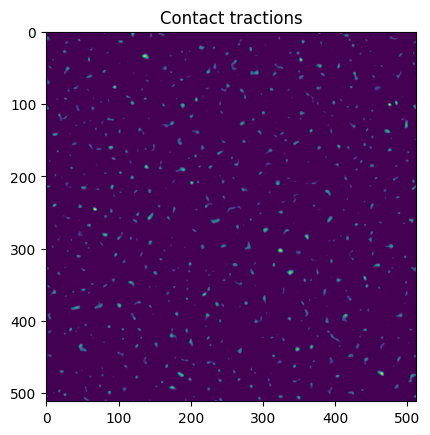

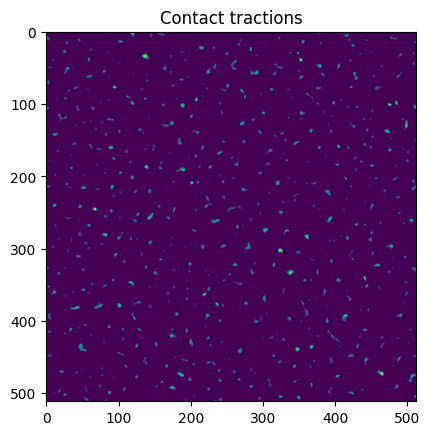

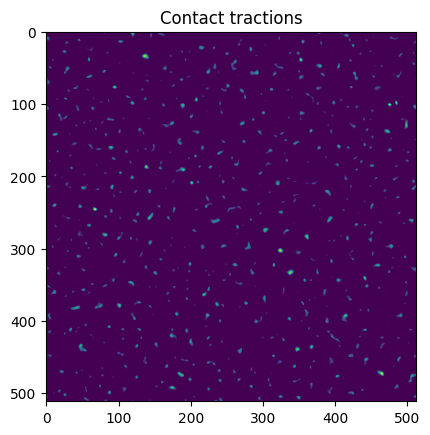

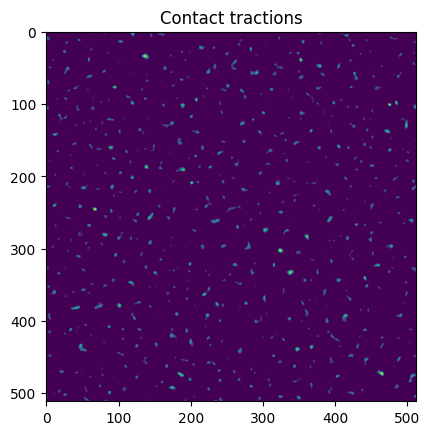

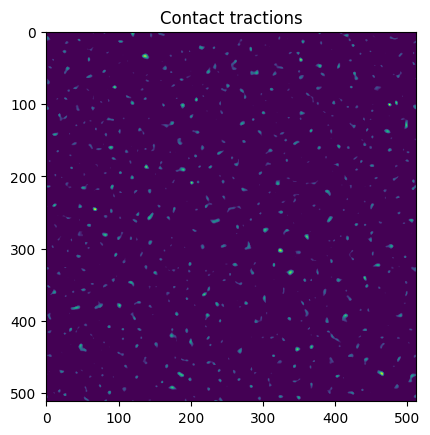

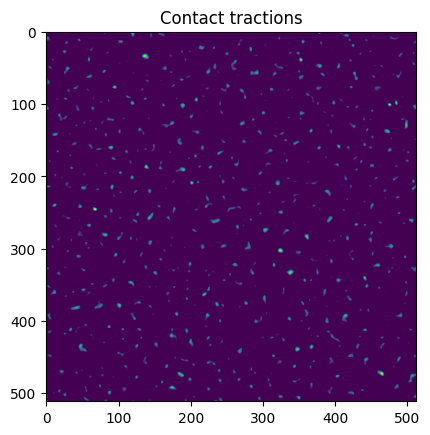

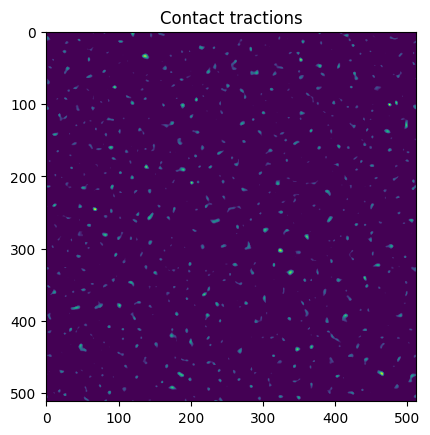

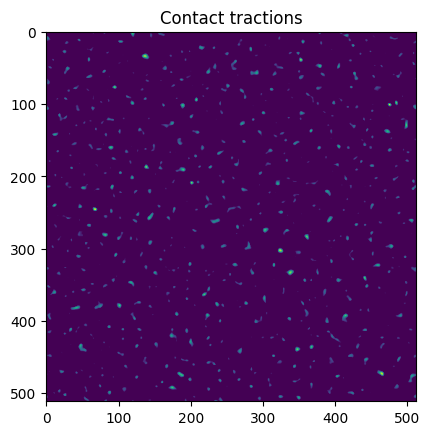

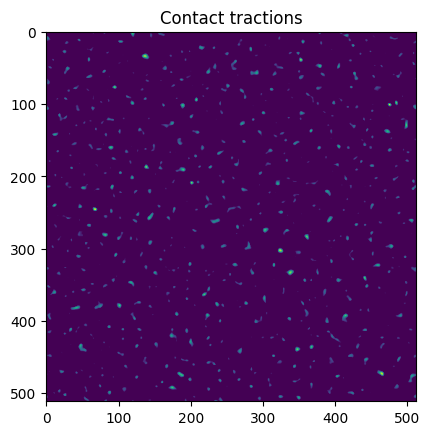

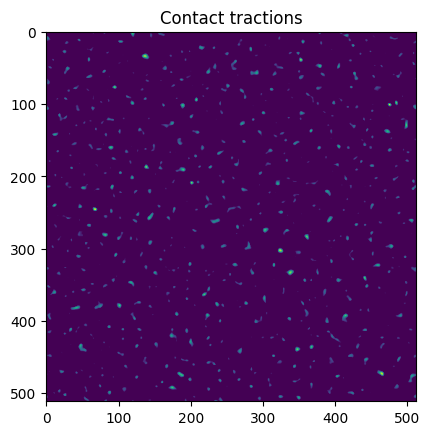

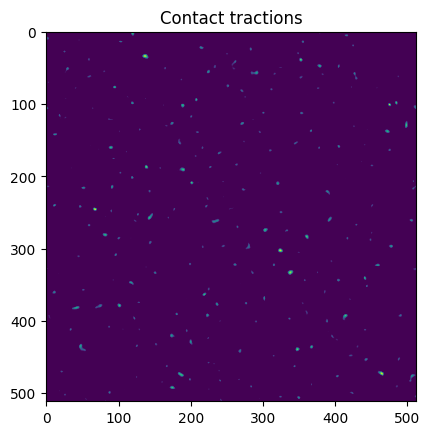

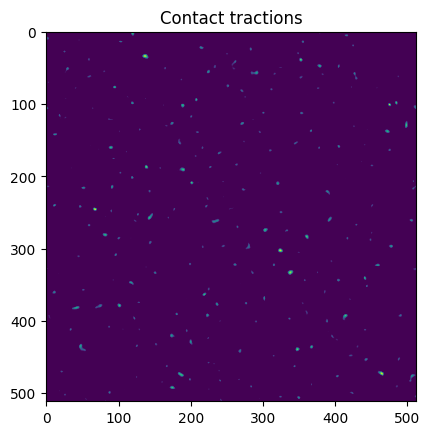

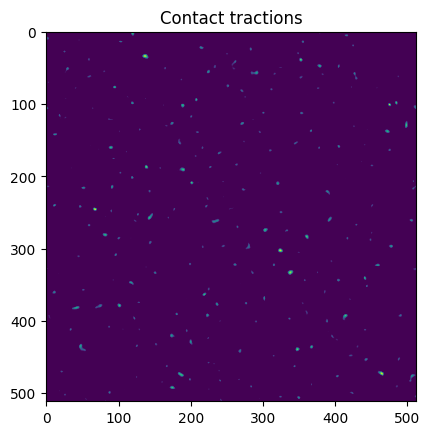

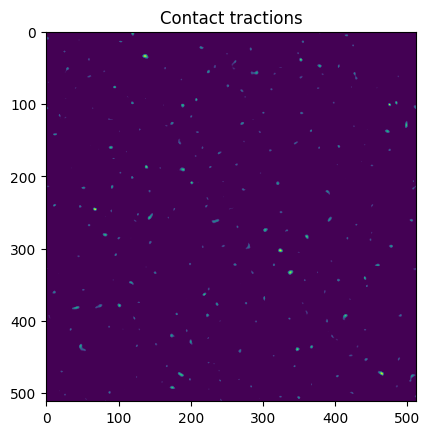

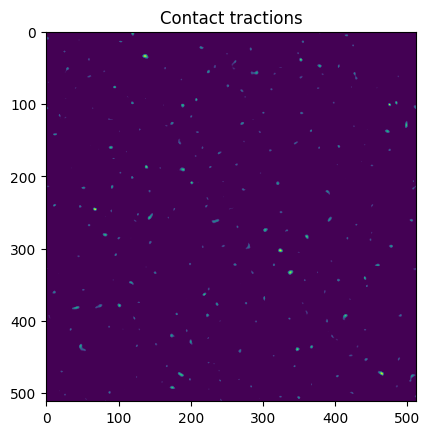

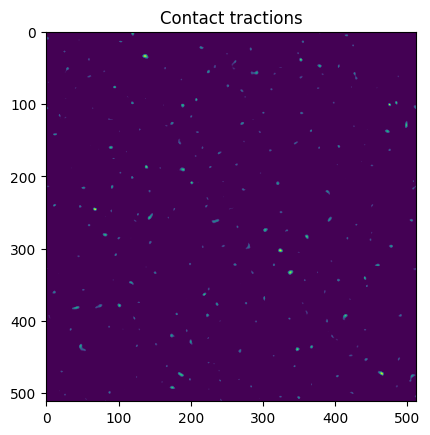

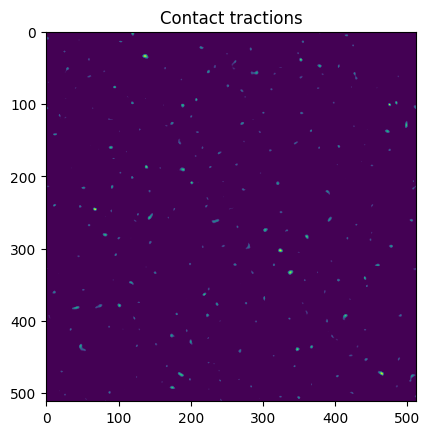

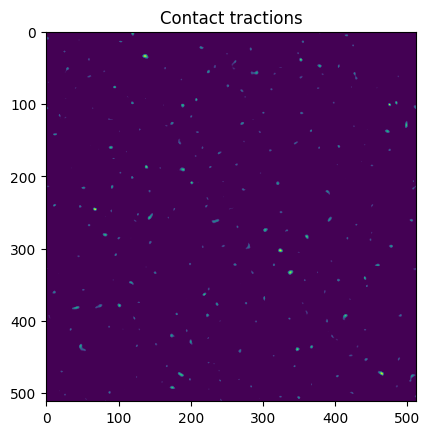

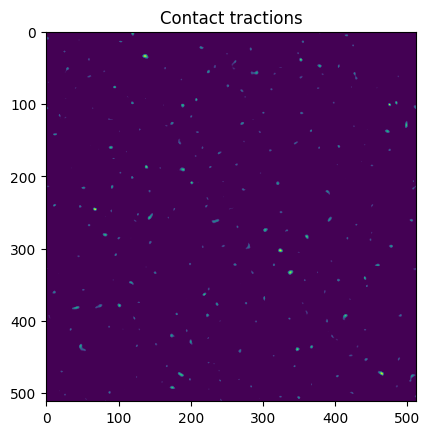

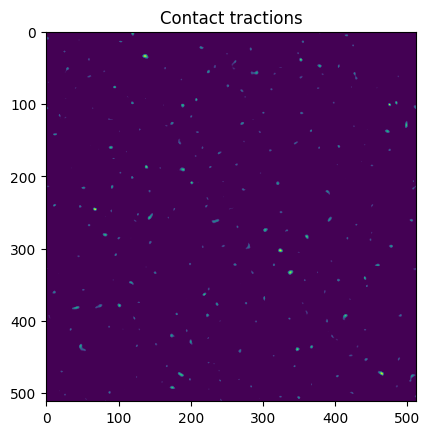

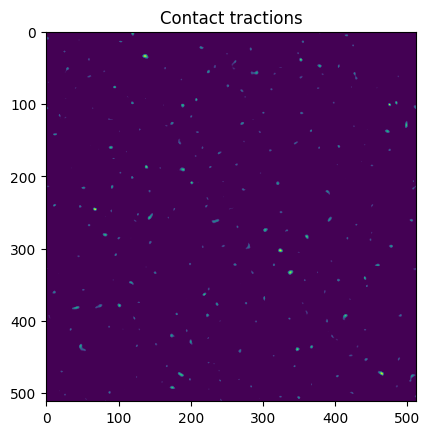

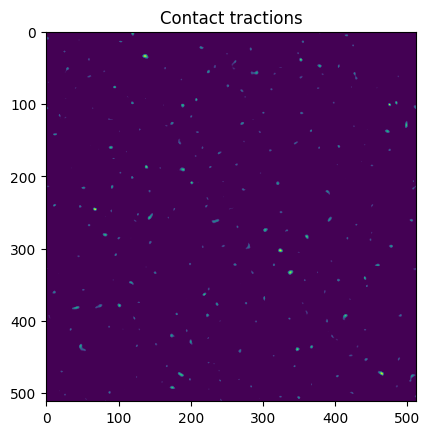

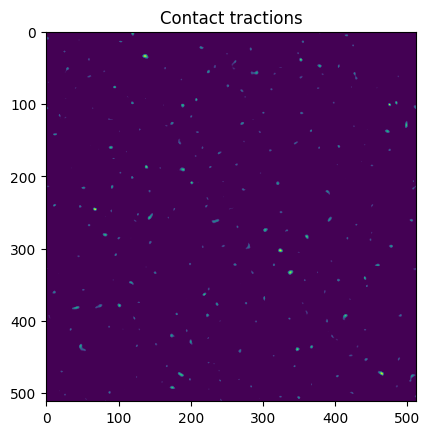

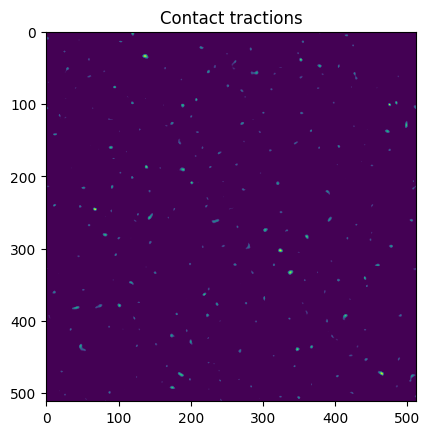

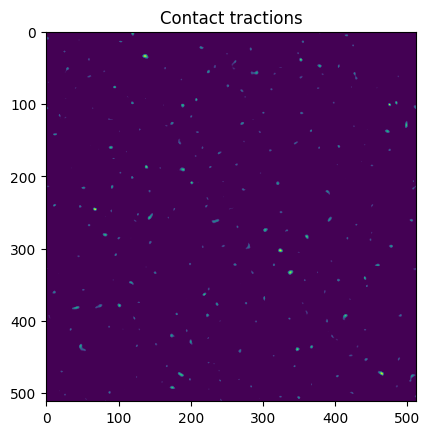

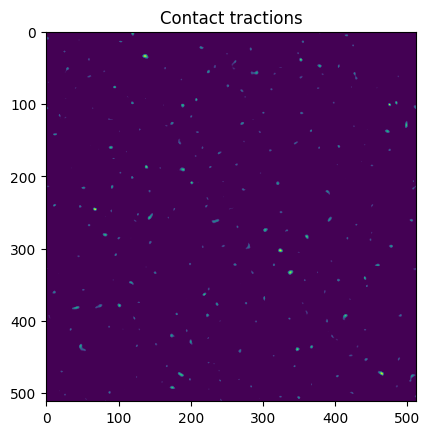

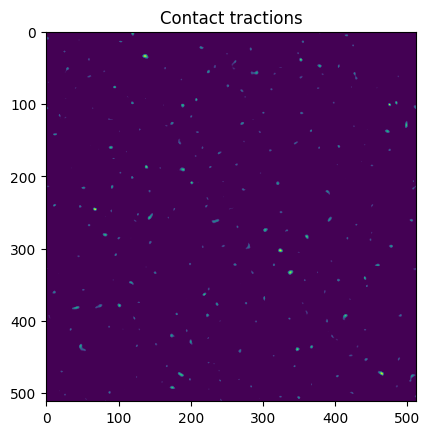

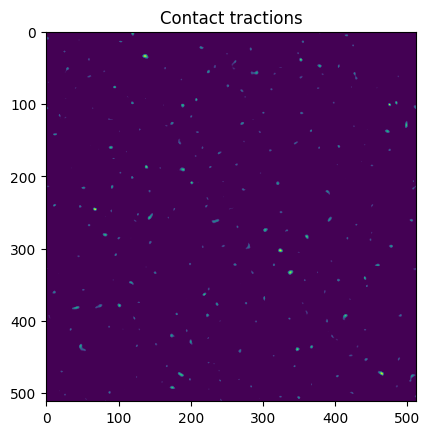

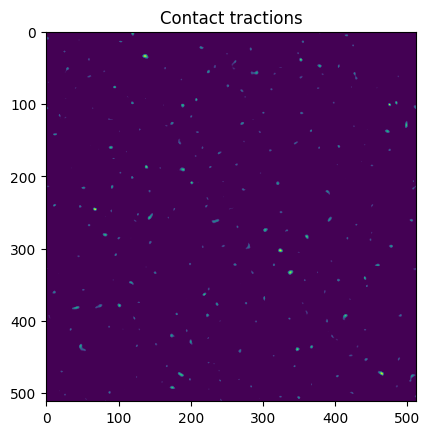

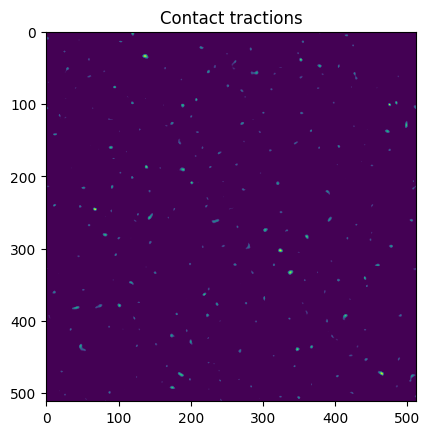

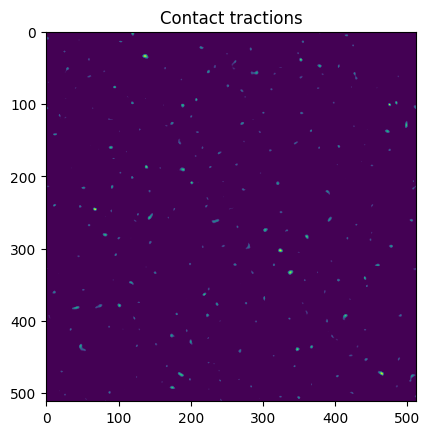

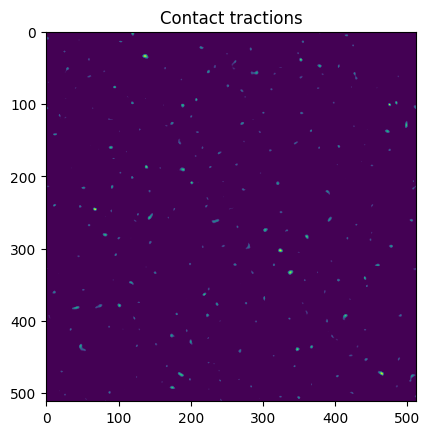

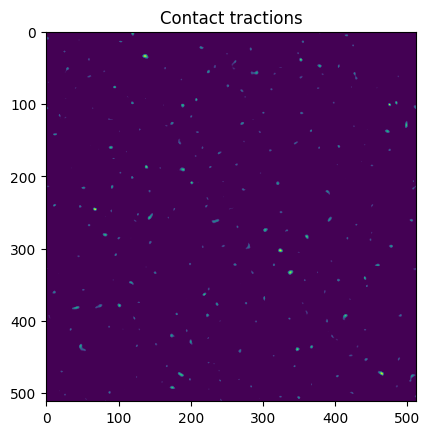

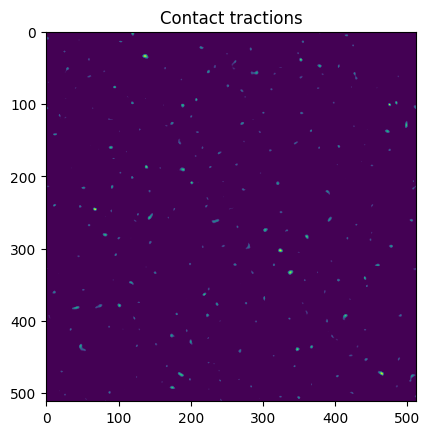

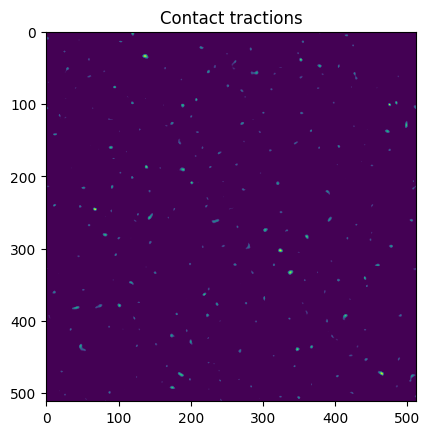

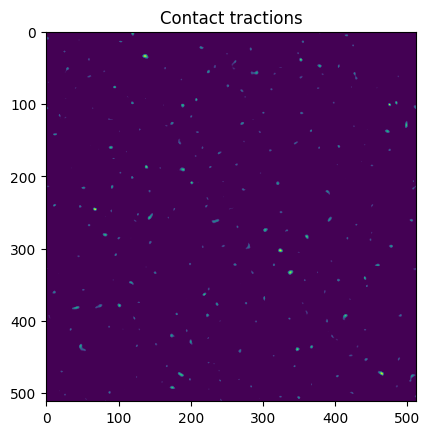

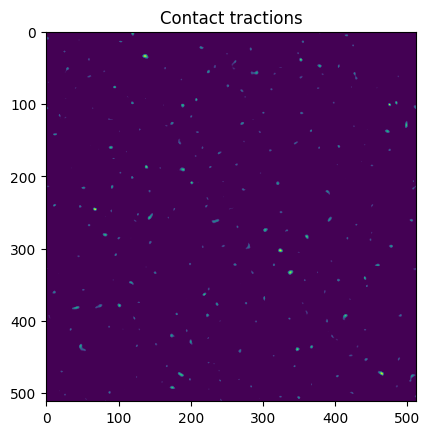

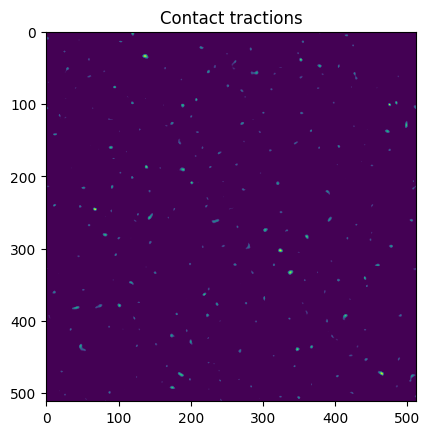

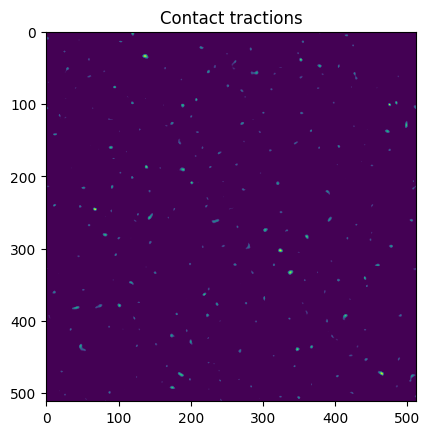

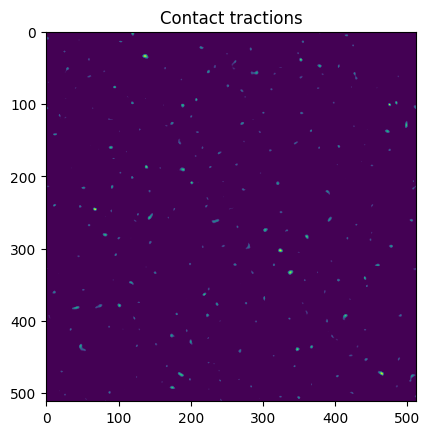

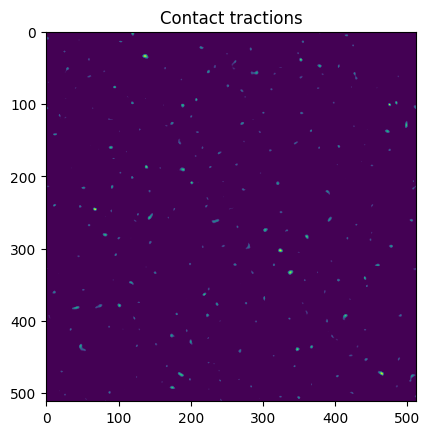

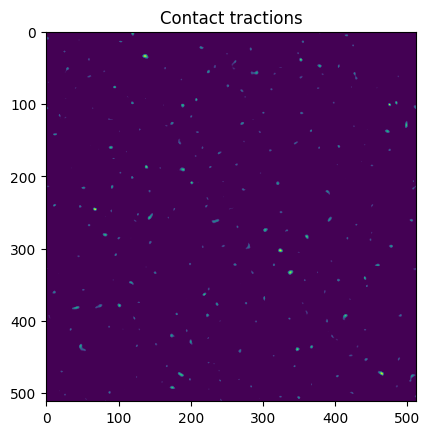

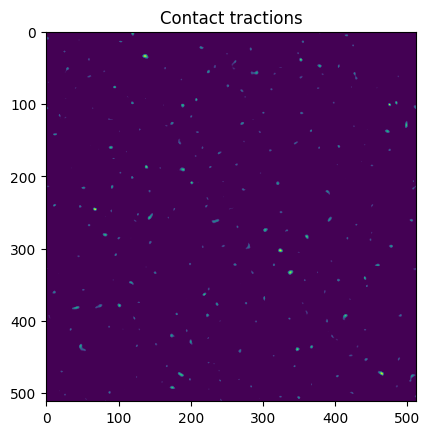

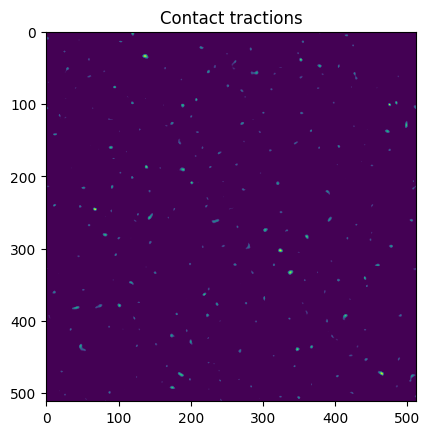

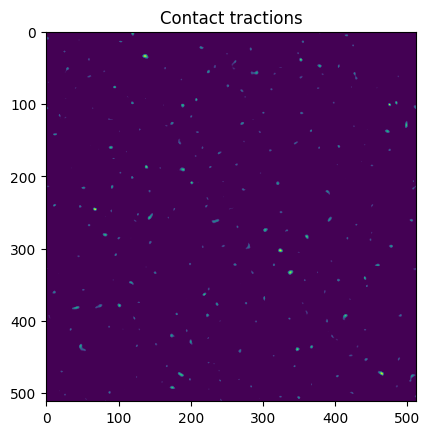

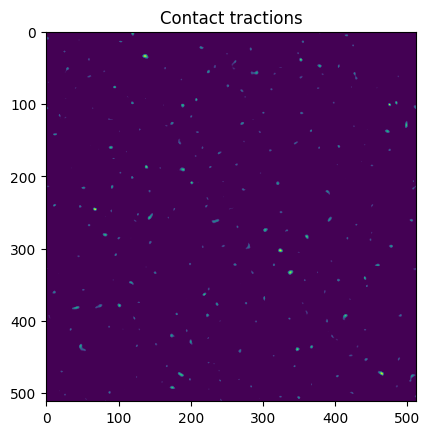

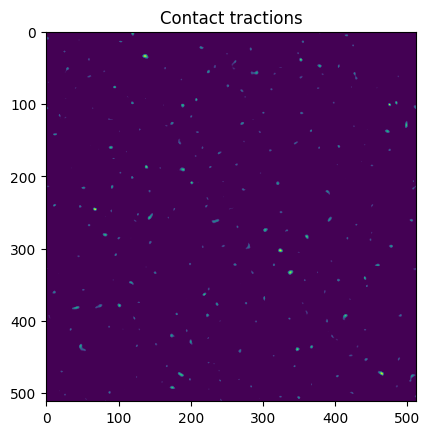

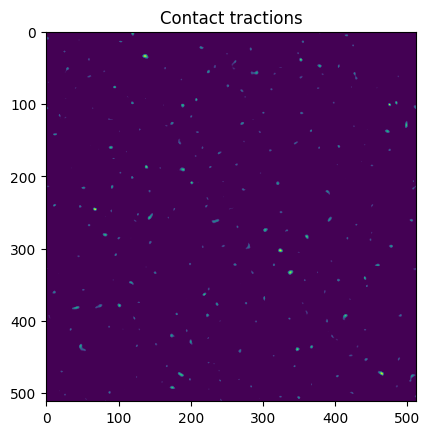

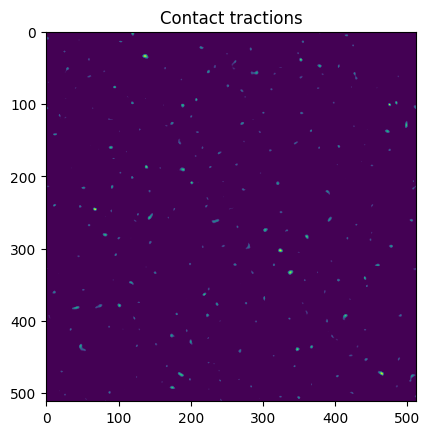

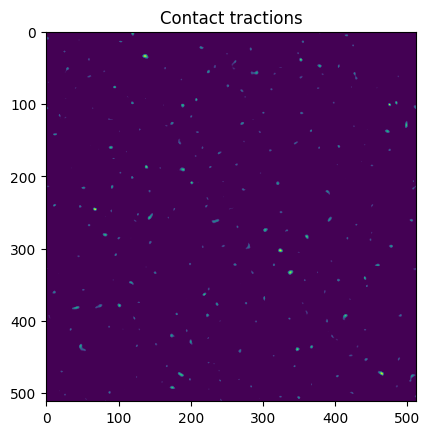

In [16]:
solver.reset()
# Solve for target pressure
for i in range(time_steps):
    if i < 10:
        solver.solve(p_target1)
    else:
        solver.solve(p_target2)
    plt.figure()
    plt.imshow(model.traction)
    plt.title('Contact tractions')
    print(model.traction.mean())

plt.show()


[1] Dillavou, Sam, and Shmuel M. Rubinstein. ‘Nonmonotonic Aging and Memory in a Frictional Interface’. Physical Review Letters 120, no. 22 (1 June 2018): 224101. https://doi.org/10.1103/PhysRevLett.120.224101.

[2] Wayne Chen, W., Q. Jane Wang, Z. Huan, and X. Luo. ‘Semi-Analytical Viscoelastic Contact Modeling of Polymer-Based Materials’. Journal of Tribology 133, no. 4 (1 October 2011): 041404. https://doi.org/10.1115/1.4004928.

[3] Kumar, M. V. R., and Narasimhan, R., 2004, “Analysis of Spherical Indentation of Linear Viscoelastic Materials,” Curr. Sci., 87, pp. 1088–1095.
